# Death to Cluster Models; Long Live Context Encoders
Outline:
- Regression: population vs. cluster vs. context-specific models (compared on MSE and L2)
- Networks: population vs. cluster vs. context-specific models (compared on L2)

We don't see all values of C but with a context encoder we can fill in the gaps rather than referring to the nearest cluster. This is important because gaps often represent:

- Undersampled / underrepresented patient populations
- Undocumented / undiscovered treatments
- Rare cell types / diseases / risk factors

In [483]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from sklearn.cluster import KMeans
from contextualized.regression import ContextualizedRegression, RegressionTrainer

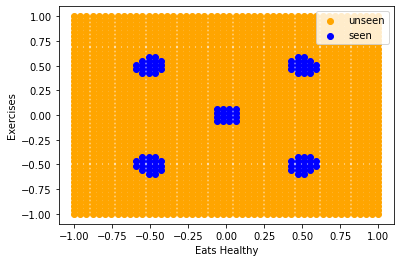

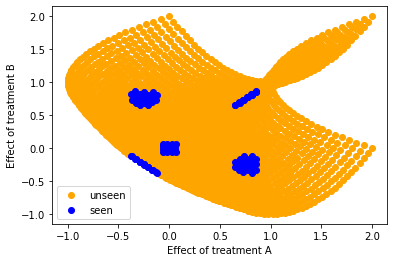

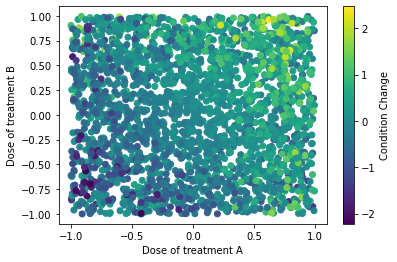

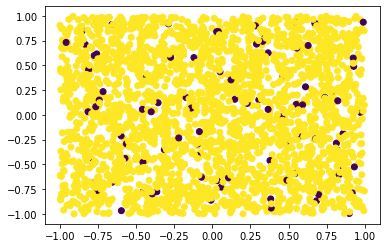

In [215]:
n_z = 50
Z_space = np.linspace(-1, 1, n_z)
Z = np.zeros((n_z**2, 2))
for i, z_i in enumerate(Z_space):
    for j, z_j in enumerate(Z_space):
        Z[i * n_z + j] = [z_i, z_j]
z_samples = 1
Z_labels = np.repeat(Z, z_samples, axis=0)
C = Z_labels.copy()

W = np.zeros_like(Z_labels)
W[:,0] = C[:,0] + C[:,1]**2 
W[:,1] = C[:,0]**2 + C[:,1] 
W = np.repeat(W, z_samples, axis=0)
# W += np.random.normal(0, .1, W.shape)
X = np.random.uniform(-1, 1, W.shape)
Y = (X * W).sum(axis=1)[:, np.newaxis]
Y += np.random.normal(0, .1, Y.shape)

def get_idx(Z):
    dist = lambda a, b: np.sqrt(np.sum((a - b)**2)) 
    gap_centers = np.array([
        [0, 0],
        [.5, .5],
        [.5, -.5],
        [-.5, .5],
        [-.5, -.5],
    ])
    gap_radius = .1
    gap_idx = np.ones(len(Z))
    for i, z in enumerate(Z):
        for gap_center in gap_centers:
            if dist(z, gap_center) < gap_radius:
                gap_idx[i] = 0
    return gap_idx
    
    
gap_idx = get_idx(Z_labels)
train_idx, test_idx = gap_idx == 0, gap_idx == 1
split = lambda arr: (arr[train_idx], arr[test_idx])
Z_train, Z_test = split(Z_labels)
C_train, C_test = split(C)
W_train, W_test = split(W)
X_train, X_test = split(X)
Y_train, Y_test = split(Y)

plt.scatter(C_test[:,0], C_test[:,1], c='orange', label='unseen')
plt.scatter(C_train[:,0], C_train[:,1], c='blue', label='seen')
plt.xlabel('Eats Healthy')
plt.ylabel('Exercises')
plt.legend()
plt.show()
# plt.scatter(W[:,0], W[:,1], c=gap_idx)
plt.scatter(W_test[:,0], W_test[:,1], c='orange', label='unseen')
plt.scatter(W_train[:,0], W_train[:,1], c='blue', label='seen')

plt.xlabel('Effect of treatment A')
plt.ylabel('Effect of treatment B')
plt.legend()
plt.show()

plt.scatter(X[:,0], X[:,1], c=Y)
plt.xlabel('Dose of treatment A')
plt.ylabel('Dose of treatment B')
plt.colorbar(label='Condition Change')
plt.show()
plt.scatter(X[:,0], X[:,1], c=gap_idx)
plt.show()

In [216]:
# Models
mse = lambda true, pred: ((true - pred)**2).mean()

class NaiveRegression:
    def __init__(self):
        pass
    
    def fit(self, X, Y):
        self.w = np.linalg.inv(X.T @ X) @ X.T @ Y
        return self
        
    def predict_w(self, X):
        return np.tile(self.w.T, (len(X), 1))
    
    def predict_y(self, X):
        w_hat = self.predict_w(X)
        y_hat = (X * w_hat).sum(axis=1)[:, np.newaxis]
        return y_hat


class ClusterRegression:
    def __init__(self, K):
        self.K = K
        self.kmeans = KMeans(n_clusters=K)
        self.models = {k: NaiveRegression() for k in range(K)}
    
    def fit(self, C, X, Y):
        self.kmeans.fit(C)
        for k in range(self.K):
            k_idx = self.kmeans.labels_ == k
            X_k, Y_k = X[k_idx], Y[k_idx]
            self.models[k].fit(X_k, Y_k)
        return self
            
    def predict_l(self, C):
        return self.kmeans.predict(C)
    
    def predict_w(self, C, X):
        labels = self.predict_l(C)
        w_hat = np.zeros_like(X)
        for label in np.unique(labels):
            l_idx = labels == label
            X_l = X[l_idx]
            w_hat[l_idx] = self.models[label].predict_w(X_l)
        return w_hat
    
    def predict_y(self, C, X):
        labels = self.predict_l(C)
        y_hat = np.zeros((len(X), 1))
        for label in np.unique(labels):
            l_idx = labels == label
            X_l = X[l_idx]
            y_hat[l_idx] = self.models[label].predict_y(X_l)
        return y_hat

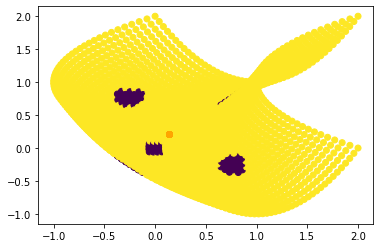

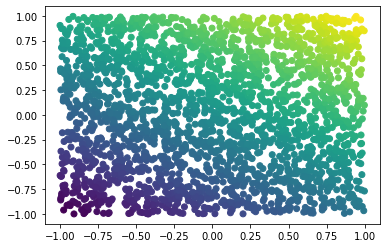

mse: 0.3042650170096122, l2: 0.4834743453460351


In [217]:
# Population regression
naive_model = NaiveRegression().fit(X_train, Y_train)
w_hat = naive_model.predict_w(X_test)
y_hat = naive_model.predict_y(X_test)

plt.scatter(W[:,0], W[:,1], c=gap_idx)
plt.scatter(w_hat[:,0], w_hat[:,1], c='orange')
plt.show()

plt.scatter(X_test[:,0], X_test[:,1], c=y_hat)
plt.show()

y_mse = mse(Y_test, y_hat)
w_mse = mse(W_test, w_hat)
print(f"mse: {y_mse}, l2: {w_mse}")

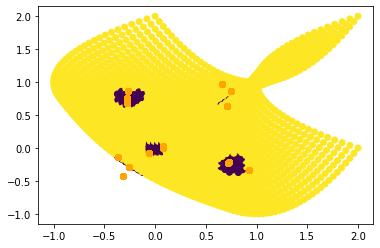

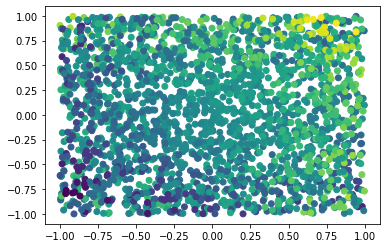

mse: 0.10227954557574684, l2: 0.15764626038126348


In [218]:
# Cluster regression
cluster_model = ClusterRegression(15).fit(C_train, X_train, Y_train)
w_hat = cluster_model.predict_w(C_test, X_test)
y_hat = cluster_model.predict_y(C_test, X_test)

plt.scatter(W[:,0], W[:,1], c=gap_idx)
plt.scatter(w_hat[:,0], w_hat[:,1], c='orange')
plt.show()

plt.scatter(X_test[:,0], X_test[:,1], c=y_hat)
plt.show()

y_mse = mse(Y_test, y_hat)
w_mse = mse(W_test, w_hat)
print(f"mse: {y_mse}, l2: {w_mse}")

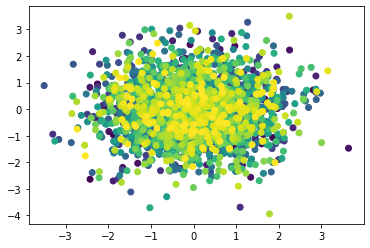

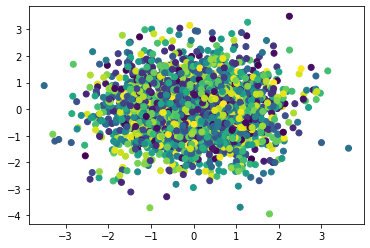

In [239]:
# noise-context sanity check
noise = np.random.normal(0, 1, (len(C), 6))
noise_train, noise_test = split(noise)

plt.scatter(noise[:,0], noise[:,1], c=C[:,0])
plt.show()
plt.scatter(noise[:,0], noise[:,1], c=C[:,1])
plt.show()

In [240]:
encoder_kwargs = {'width': 50, 'layers': 2}
model = ContextualizedRegression(noise.shape[-1], X.shape[-1], Y.shape[-1], encoder_kwargs=encoder_kwargs)
train_dataloader = model.dataloader(noise_train, X_train, Y_train, batch_size=1)
test_dataloader = model.dataloader(noise_test, X_test, Y_test, batch_size=100)
trainer = RegressionTrainer(max_epochs=5, auto_lr_find=True)
trainer.fit(model, train_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/Caskroom/miniconda/base/envs/correlator/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")

  | Name      | Type             | Params
-----------------------------------------------
0 | metamodel | SubtypeMetamodel | 890   
-----------------------------------------------
890       Trainable params
0         Non-trainable params
890       Total params
0.004     Total estimated model params size (MB)
/usr/local/Caskroom/miniconda/base/envs/correlator/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing

Training: 0it [00:00, ?it/s]

/usr/local/Caskroom/miniconda/base/envs/correlator/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 92it [00:00, ?it/s]

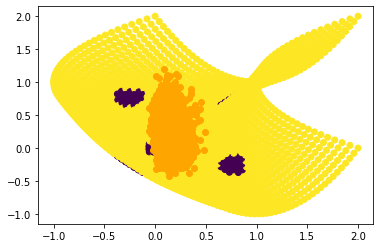

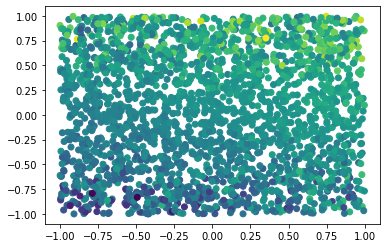

mse: 0.32317718383545374, l2: 0.5209225672603505


In [241]:
w_hat, _ = trainer.predict_params(model, test_dataloader)
w_hat = w_hat.squeeze()
y_hat = (X_test * w_hat).sum(axis=1)[:,np.newaxis]

plt.scatter(W[:,0], W[:,1], c=gap_idx)
plt.scatter(w_hat[:,0], w_hat[:,1], c='orange')
plt.show()

plt.scatter(X_test[:,0], X_test[:,1], c=y_hat)
plt.show()

y_mse = mse(Y_test, y_hat)
w_mse = mse(W_test, w_hat)
print(f"mse: {y_mse}, l2: {w_mse}")

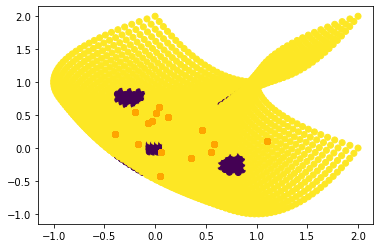

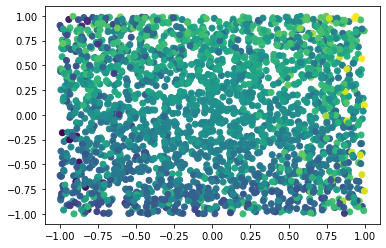

mse: 0.36434366078753583, l2: 0.5960439623331008


In [242]:
# Cluster regression on noise
cluster_model = ClusterRegression(15).fit(noise_train, X_train, Y_train)
w_hat = cluster_model.predict_w(noise_test, X_test)
y_hat = cluster_model.predict_y(noise_test, X_test)

plt.scatter(W[:,0], W[:,1], c=gap_idx)
plt.scatter(w_hat[:,0], w_hat[:,1], c='orange')
plt.show()

plt.scatter(X_test[:,0], X_test[:,1], c=y_hat)
plt.show()

y_mse = mse(Y_test, y_hat)
w_mse = mse(W_test, w_hat)
print(f"mse: {y_mse}, l2: {w_mse}")

In [243]:
# Contextualized model
encoder_kwargs = {'width': 50, 'layers': 2}
model = ContextualizedRegression(C.shape[-1], X.shape[-1], Y.shape[-1], encoder_kwargs=encoder_kwargs)
train_dataloader = model.dataloader(C_train, X_train, Y_train, batch_size=2)
test_dataloader = model.dataloader(C_test, X_test, Y_test, batch_size=100)
trainer = RegressionTrainer(max_epochs=50, auto_lr_find=True)
trainer.fit(model, train_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/Caskroom/miniconda/base/envs/correlator/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:122: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")

  | Name      | Type             | Params
-----------------------------------------------
0 | metamodel | SubtypeMetamodel | 690   
-----------------------------------------------
690       Trainable params
0         Non-trainable params
690       Total params
0.003     Total estimated model params size (MB)
/usr/local/Caskroom/miniconda/base/envs/correlator/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing

Training: 0it [00:00, ?it/s]

/usr/local/Caskroom/miniconda/base/envs/correlator/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:132: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 46it [00:00, ?it/s]

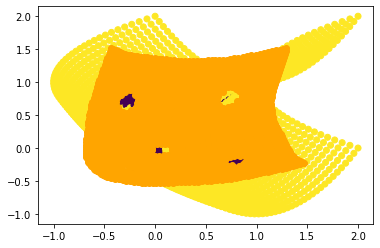

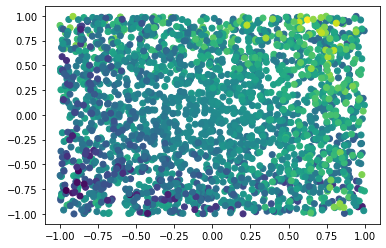

mse: 0.05153970265636406, l2: 0.06917778142294907


In [244]:
w_hat, _ = trainer.predict_params(model, test_dataloader)
w_hat = w_hat.squeeze()
y_hat = (X_test * w_hat).sum(axis=1)[:,np.newaxis]

plt.scatter(W[:,0], W[:,1], c=gap_idx)
plt.scatter(w_hat[:,0], w_hat[:,1], c='orange')
plt.show()

plt.scatter(X_test[:,0], X_test[:,1], c=y_hat)
plt.show()

y_mse = mse(Y_test, y_hat)
w_mse = mse(W_test, w_hat)
print(f"mse: {y_mse}, l2: {w_mse}")

# Networks
- Bayesian networks: y = w(c) * x + eps
- Correlation networks: y = w(c) * x + eps(C)

In [513]:
import tensorflow as tf
from contextualized.notmad import NOTMAD
from contextualized.networks import ContextualizedCorrelation, NetworkTrainer

In [521]:
n = 500
C = np.linspace(0, 1, n).reshape((n, 1))
blank = np.zeros_like(C)
W_00 = blank
W_01 = C - .5
W_02 = (C - .7) * 2
W_03 = blank
W_10 = blank
W_11 = blank
W_12 = blank
W_13 = C
W_20 = blank
W_21 = blank
W_22 = blank
W_23 = (C * 3) / 2
W_30 = blank
W_31 = blank
W_32 = blank
W_33 = blank
W = np.array([
    [W_00, W_01, W_02, W_03],
    [W_10, W_11, W_12, W_13],
    [W_20, W_21, W_22, W_23],
    [W_30, W_31, W_32, W_33],
]).squeeze()
W = np.transpose(W, (2, 0, 1))

X_pre = np.random.uniform(-1, 1, (n, 4))
# eps = np.random.normal(0, .1, (n, 4))
X = np.zeros_like(X_pre)
for i, (w, X_p) in enumerate(zip(W, X_pre)):
    eps = np.random.normal(0, .1, 4)
    X[i] = w @ X_p + eps

idx = np.logical_and(C > .3, C < .6).squeeze()
test_idx = np.argwhere(idx).squeeze()
train_idx = np.argwhere(~idx).squeeze()
split = lambda arr: (arr[train_idx], arr[test_idx])
W_train, W_test = split(W)
C_train, C_test = split(C)
X_train, X_test = split(X)

In [523]:
W_train[-1]

array([[0. , 0.5, 0.6, 0. ],
       [0. , 0. , 0. , 1. ],
       [0. , 0. , 0. , 1.5],
       [0. , 0. , 0. , 0. ]])

In [515]:
def fit_notmad(sample_specific_loss_params, archetype_loss_params, 
                  C_train, X_train, k, project, notears_pop, base_predictor):
    init_mat = np.random.uniform(-0.01, 0.01, size=(k, X_train.shape[-1], X_train.shape[-1])) #np.zeros((k, X_train.shape[-1], X_train.shape[-1])) #
    make_notmad = lambda: NOTMAD(
        C_train.shape, X_train.shape, k,
        sample_specific_loss_params, archetype_loss_params,
        n_encoder_layers=1, encoder_width=32,
        activation='linear', init_mat=init_mat,
        learning_rate=1e-3, project_archs_to_dag=project, # TODO: should this be variable?
        project_distance=1.0,
        context_activity_regularizer=tf.keras.regularizers.l1(0),
        use_compatibility=False, update_compat_by_grad=False,
        pop_model=None, base_predictor=base_predictor
    )
    notmad = make_notmad()
    notmad.fit(C_train, X_train, batch_size=1, epochs=20, es_patience=2, verbose=1)
    return notmad

k = 10
sample_specific_loss_params = {'l1': 0., 'alpha': 2e1, 'rho': 1e0}
archetype_loss_params = {'l1': 0., 'alpha': 1e-1, 'rho': 1e-2}

notmad_nobase = fit_notmad(
    sample_specific_loss_params, archetype_loss_params,
    C_train, X_train, k, project=True, notears_pop=None, base_predictor=None)
preds_nobase = notmad_nobase.predict_w(C_test, project_to_dag=True).squeeze()

NOTMAD Training:   0%|                                                             0/20 ETA: ?s,  ?epochs/s

In [516]:
preds_nobase

array([[[ 0.        ,  0.        ,  0.03861954,  0.        ],
        [ 0.10209327,  0.        ,  1.1883881 ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.16773921, -0.03258425,  0.05413265,  0.        ]],

       [[ 0.        ,  0.        ,  0.03880299,  0.        ],
        [ 0.10098079,  0.        ,  1.192973  ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.16680674, -0.03314301,  0.05367675,  0.        ]],

       [[ 0.        ,  0.        ,  0.03898187,  0.        ],
        [ 0.0998939 ,  0.        ,  1.197448  ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.16589597, -0.03368879,  0.05323137,  0.        ]],

       ...,

       [[ 0.        ,  0.        ,  0.04505127,  0.        ],
        [ 0.06107945,  0.        ,  1.3534756 ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ],
        [ 0.13366991, -0.0530779 ,  0.03732064,  0.

## Correlation nets

Global correlation: [[0.91975262]]


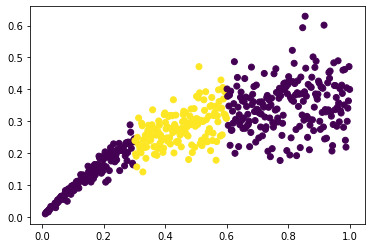

In [479]:
n = 500
C = np.linspace(.01, 1, n).reshape((n, 1))
w = np.exp(-C)
X = np.linspace(.01, 1, n).reshape((n, 1))
eps = np.random.normal(0, C*.1, (n, 1))
Y = X * w + eps
V = np.concatenate((X, Y), axis=-1)

idx = np.logical_and(C > .3, C < .6).squeeze()
test_idx = np.argwhere(idx).squeeze()
train_idx = np.argwhere(~idx).squeeze()
split = lambda arr: (arr[train_idx], arr[test_idx])
C_train, C_test = split(C)
X_train, X_test = split(X)
Y_train, Y_test = split(Y)
V_train, V_test = split(V)

w_xy = np.linalg.inv(X.T @ X) @ X.T @ Y
w_yx = np.linalg.inv(Y.T @ Y) @ Y.T @ X
print(f'Global correlation: {w_xy * w_yx}')

plt.scatter(X, Y, c=idx)
plt.show()

In [480]:
# link_fn = lambda x: torch.nn.functional.softmax(x, dim=1)
model = ContextualizedCorrelation(C.shape[-1], V.shape[-1])
train_dataset = model.dataloader(C_train, V_train, batch_size=1)
trainer = NetworkTrainer(max_epochs=5, auto_lr_find=True)
trainer.fit(model, train_dataset)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name      | Type               | Params
-------------------------------------------------
0 | metamodel | TasksplitMetamodel | 895   
-------------------------------------------------
895       Trainable params
0         Non-trainable params
895       Total params
0.004     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Predicting: 1396it [00:00, ?it/s]

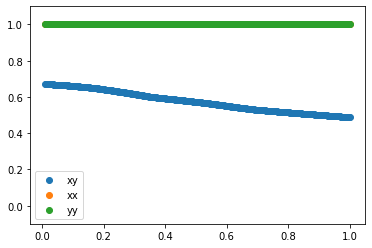

In [481]:
dataset = model.dataloader(C, V, batch_size=10)
corrs = trainer.predict_network(model, dataset)
plt.scatter(C.squeeze(), corrs[:,1,0]/(.5 * corrs[:,0,0] + .5 * corrs[:,1,1]) , label='xy')
plt.scatter(C.squeeze(), corrs[:,0,0]/corrs[:,0,0], label='xx')
plt.scatter(C.squeeze(), corrs[:,1,1]/corrs[:,1,1], label='yy')
plt.ylim(-.1, 1.1)
plt.legend()
plt.show()

In [434]:
trainer.predict_network(model, dataset)

Predicting: 697it [00:00, ?it/s]

array([[[ 1.47179680e-02, -8.50853627e-05],
        [-8.50853627e-05,  1.48344627e-02]],

       [[ 1.48917658e-02, -8.48806145e-05],
        [-8.48806145e-05,  1.50749382e-02]],

       [[ 1.50665782e-02, -8.46627307e-05],
        [-8.46627307e-05,  1.53173435e-02]],

       ...,

       [[ 4.74226525e-01,  6.04577742e-03],
        [ 6.04577742e-03,  1.05177042e+00]],

       [[ 4.74907233e-01,  6.05603813e-03],
        [ 6.05603813e-03,  1.05342985e+00]],

       [[ 4.75588758e-01,  6.06630650e-03],
        [ 6.06630650e-03,  1.05509058e+00]]])

In [435]:
trainer.predict_params(model, dataset)[0]

Predicting: 697it [00:00, ?it/s]

array([[[ 0.12131763,  0.01476792],
        [-0.0057615 ,  0.12179681]],

       [[ 0.12203182,  0.01488138],
        [-0.00570381,  0.12278004]],

       [[ 0.12274599,  0.01499485],
        [-0.00564612,  0.12376326]],

       ...,

       [[ 0.68864107,  0.07753937],
        [ 0.07797042,  1.02555859]],

       [[ 0.68913513,  0.07759   ],
        [ 0.07805179,  1.02636731]],

       [[ 0.68962944,  0.07764062],
        [ 0.07813316,  1.02717602]]])